# Data Wrangling

In [395]:
#import all needed packges
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Gather

In [396]:
#read csv file
arc_df = pd.read_csv('twitter-archive-enhanced.csv')
arc_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [397]:
#read URL
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = 'image-predictions.tsv'
response = requests.get(url)
with open(os.path.join(file_name), mode='wb') as file:
    file.write(response.content)

In [398]:
# Import the tweet image predictions TSV file into a DataFrame
img_df = pd.read_csv(file_name, sep='\t')
img_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [399]:
# Declare Twitter API keys and access tokens
consumer_key = 'xxxxxxxxxx'
consumer_secret = 'xxxxxxxxxx'

access_token = 'xxxxxxxxxx'
access_secret = 'xxxxxxxxxx'



auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [400]:
errors = []
if not os.path.isfile('tweet_json.txt'):
    # create the file and write on it
    with open ('tweet_json.txt', 'w') as file:
        for tweet_id in arc_df['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True)
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)

Error on tweet id 888202515573088257;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 873697596434513921;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 872668790621863937;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 872261713294495745;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 869988702071779329;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 866816280283807744;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 861769973181624320;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 856602993587888130;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 851953902622658560;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 845459076796616705;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 844704788403

Rate limit reached. Sleeping for: 336


Error on tweet id 754011816964026368;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 680055455951884288;[{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 309


In [401]:
# List of dictionaries to read tweet's JSON data line by line and later convert to a DataFrame
df_list = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        status = json.loads(line)
       # print(status)
       # break
        # Append to list of dictionaries
        df_list.append({'tweet_id': status['id'],
                        'retweet_count': status['retweet_count'],
                        'favorite_count': status['favorite_count']
                       })

# Create a DataFrame with tweet ID, retweet count, favorite count and display_text_range
twt_df = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
twt_df

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7340,34979
1,892177421306343426,5475,30284
2,891815181378084864,3621,22785
3,891689557279858688,7529,38248
4,891327558926688256,8109,36525
...,...,...,...
2326,666049248165822465,38,93
2327,666044226329800704,122,259
2328,666033412701032449,39,107
2329,666029285002620928,41,117


In [402]:
print("The list of tweets no found" , len(errors))

The list of tweets no found 25


## Assess

### Visual and programmatic assessments

In [403]:
arc_df.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
468,817056546584727552,NaN,NaN,2017-01-05 17:13:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chloe. She fell asleep at the wheel. A...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/817056546...,11,10,Chloe,None,None,None,None
1677,682059653698686977,NaN,NaN,2015-12-30 04:44:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tess. Her main passions are shelves an...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682059653...,11,10,Tess,None,None,None,None
835,768193404517830656,NaN,NaN,2016-08-23 21:09:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Gerald. He's a fairly exotic doggo. Floof...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/768193404...,8,10,Gerald,doggo,None,None,None
786,774757898236878852,NaN,NaN,2016-09-10 23:54:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Finley. She's a Beneboop Cumbersplash....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/774757898...,12,10,Finley,None,None,None,None
1446,696490539101908992,6.964887e+17,4.196984e+09,2016-02-08 00:27:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After reading the comments I may have overesti...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
1723,680100725817409536,NaN,NaN,2015-12-24 19:00:23 +0000,"<a href=""https://about.twitter.com/products/tw...",This pupper is not coming inside until she cat...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680100725...,11,10,None,None,None,pupper,None
1019,746790600704425984,NaN,NaN,2016-06-25 19:42:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you just can't resist... 10/10 topnotch t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746790600...,10,10,None,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None
1949,673689733134946305,NaN,NaN,2015-12-07 02:25:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're having a blast and remember tomorr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673689733...,11,10,None,None,None,None,None
1951,673686845050527744,NaN,NaN,2015-12-07 02:13:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is George. He's upset that the 4th of Jul...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673686845...,11,10,George,None,None,None,None


In [404]:
img_df.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
845,695095422348574720,https://pbs.twimg.com/media/CaV5mRDXEAAR8iG.jpg,1,papillon,0.227784,True,Chihuahua,0.218128,True,Border_collie,0.093457,True
136,668507509523615744,https://pbs.twimg.com/media/CUcECBYWcAAzFRg.jpg,1,basenji,0.055379,True,Shetland_sheepdog,0.054322,True,whippet,0.051913,True
309,671538301157904385,https://pbs.twimg.com/media/CVHIhi2WsAEgdKk.jpg,1,park_bench,0.194211,False,water_bottle,0.071870,False,beacon,0.053433,False
946,704499785726889984,https://pbs.twimg.com/media/Ccbi0UGWoAA4fwg.jpg,1,Chihuahua,0.376541,True,Siamese_cat,0.098057,False,Labrador_retriever,0.085211,True
465,675006312288268288,https://pbs.twimg.com/media/CV4aqCwWsAIi3OP.jpg,1,boxer,0.654697,True,space_heater,0.043389,False,beagle,0.042848,True
1164,735256018284875776,https://pbs.twimg.com/media/CjQnclkVEAA4pnK.jpg,1,Staffordshire_bullterrier,0.523191,True,French_bulldog,0.351104,True,doormat,0.028075,False
948,704819833553219584,https://pbs.twimg.com/media/CcgF5ovW8AACrEU.jpg,1,guinea_pig,0.994776,False,hamster,0.004069,False,wood_rabbit,0.000206,False
2029,882762694511734784,https://pbs.twimg.com/media/DEAz_HHXsAA-p_z.jpg,1,Labrador_retriever,0.850050,True,Chesapeake_Bay_retriever,0.074257,True,flat-coated_retriever,0.015579,True
1921,856526610513747968,https://pbs.twimg.com/media/C-L-aIYXgAIR0jY.jpg,1,Old_English_sheepdog,0.798481,True,Tibetan_terrier,0.060602,True,standard_poodle,0.040722,True
1061,715200624753819648,https://pbs.twimg.com/media/CeznK6IWEAEFUPq.jpg,1,Chihuahua,0.956787,True,beagle,0.008383,True,Labrador_retriever,0.008344,True


In [405]:
twt_df.sample(20)

,tweet_id,retweet_count,favorite_count
1230,710658690886586372,535,2222
671,787717603741622272,2714,10092
1300,706169069255446529,2111,3746
863,760153949710192640,30,0
1640,682788441537560576,1059,2383
1154,719551379208073216,1802,4839
623,793226087023144960,2823,9669
2165,668960084974809088,223,650
1236,710269109699739648,1067,2296
882,758099635764359168,9590,18450


In [406]:
arc_df.shape

(2356, 17)

In [407]:
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [408]:
arc_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [409]:
arc_df['tweet_id'].duplicated().sum()

0

In [410]:
arc_df['name'].value_counts().sort_index(ascending=False)

very            5
unacceptable    1
this            1
the             8
such            1
               ..
Aiden           1
Adele           1
Acro            1
Ace             1
Abby            2
Name: name, Length: 957, dtype: int64

In [411]:
arc_df[arc_df['name'] == 'a'].text

56      Here is a pupper approaching maximum borkdrive...
649     Here is a perfect example of someone who has t...
801     Guys this is getting so out of hand. We only r...
1002    This is a mighty rare blue-tailed hammer sherk...
1004    Viewer discretion is advised. This is a terrib...
1017    This is a carrot. We only rate dogs. Please on...
1049    This is a very rare Great Alaskan Bush Pupper....
1193    People please. This is a Deadly Mediterranean ...
1207    This is a taco. We only rate dogs. Please only...
1340    Here is a heartbreaking scene of an incredible...
1351    Here is a whole flock of puppers.  60/50 I'll ...
1361    This is a Butternut Cumberfloof. It's not wind...
1368    This is a Wild Tuscan Poofwiggle. Careful not ...
1382    "Pupper is a present to world. Here is a bow f...
1499    This is a rare Arctic Wubberfloof. Unamused by...
1737    Guys this really needs to stop. We've been ove...
1785    This is a dog swinging. I really enjoyed it so...
1853    This i

In [412]:
arc_df['rating_numerator'].value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [413]:
arc_df['rating_denominator'].value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [414]:
arc_df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [415]:
arc_df['text'].str.len().sort_values(ascending=False)

461     167
516     167
262     167
186     165
320     165
       ... 
409      20
1345     18
1080     18
290      18
1914     11
Name: text, Length: 2356, dtype: int64

In [416]:
img_df.shape

(2075, 12)

In [417]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [418]:
img_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [419]:
img_df['tweet_id'].duplicated().sum()

0

In [420]:
arc_df['tweet_id'].duplicated().sum()

0

In [421]:
arc_df['text'].duplicated().sum()

0

In [422]:
img_df['jpg_url'].duplicated().sum()

66

In [423]:
all_columns= pd.Series(list(arc_df)+list(img_df)+list(twt_df))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

In [424]:
img_df['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [425]:
len(arc_df[~arc_df['tweet_id'].isin(img_df['tweet_id'])])

281

In [426]:
len(arc_df[~arc_df['tweet_id'].isin(twt_df['tweet_id'])])

25

In [427]:
twt_df.shape

(2331, 3)

In [428]:
twt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [429]:
twt_df.describe()

,tweet_id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2584.648649,7304.024453
std,6.823170e+16,4372.107909,11345.267589
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,524.500000,1264.500000
50%,7.182469e+17,1205.000000,3166.000000
75%,7.986692e+17,2993.000000,8932.000000
max,8.924206e+17,74177.000000,150338.000000


### Issues

- I used the following abbreviations for simplicity when working with dataframes (archive : arc, prediction : img , , , tweets : twt)

#### Quality

##### Visual assessment

- `archive` : Column source had HTML code

- `archive` : timestamp column has unnecessary numbers '+0000'

- `archive` : Erroneous dog names starting with lowercase characters

- `archive` : Inconsistent representations:
    - Records have more than one dog stage

- `prediction` : Multiple columns for image prediction and confidence level

- `prediction` : Columns should be more descriptive such as p1, p1_conf, p1_dog and ect..

- `archive` : Columns won't be used for analysis such as
    - retweeted_status_id
    - retweeted_status_user_id 
    - retweeted_status_timestamp


##### Programmatical assessment

- `archive` : Retweeted record not orginal about 78 records of in_reply_to_status_id and in_reply_to_user_id 

- `archive` : Many dog names have incorrect extraction from the tweet text

- `prediction` : Missing image prediction data

- `archive` : Missing expanded_urls data
    
- `archive` : Erroneous data types:
    - Float instead of integer then into string such as:
        - arc.in_reply_to_status_id
        - arc.in_reply_to_user_id 
        - arc.retweeted_status_id 
        - arc.retweeted_status_user_id
    - String instead of timestamp in timestamp
    - Category instead of string in source
    - Category instead of string in doggo, floofer, pupper and puppo
    - Category instead of string in p1, p2 and p3
    - Integer instead of sting in tweet_id

- `prediction` : Erroneous data types:
    - Integer instead of sting in tweet_id

- `tweets` : Erroneous data types:
    - Integer instead of sting in tweet_id


-  `archive` : Incoreect dog names records "None" string instead of NaN

-  `archive` : Incorrect dog names such as (a, an, the, just, one, very, quite, not, actually, mad, space, infuriating, all, officially, 0, old, life, unacceptable, my, incredibly, by, his, such)

-  `archive` : Meaningful but inconsistent numerators, has values less than 10 as well as some very large numbers (e.g. 1176), however we will leave them as they are.

-  `archive` : Meaningful but inconsistent denominators, has values other than 10; however we will leave them as they are.

-  `archive` : Incorrect denominators equal 0

- `prediction` : Duplicated records for img_df.jpg_url


#### Tidiness

-  `archive` : Dog stages have a multiple columns (doggo, floofer, pupper and puppo), 1 variable in 4 columns (doggo, floofer, pupper and puppo)
- `archive`, `prediction`, `tweets`: 3 seperate dataframes


## Clean

#### Define

- Drop retweets by filtering arc.retweeted_status_id for getting the orginal tweets only 

- Drop archive tweets records which have no image id

- Drop archive tweets records which have no tweets details

- Delete columns that won't be used for analysis such as
    - arc_df.retweeted_status_id, 
    - arc_df.retweeted_status_user_id
    - arc_df.retweeted_status_timestamp
    
- Remove unnecessary numbers from timestamp column

- Convert to the correct data types:
    - Float instead of integer then confert into string such as:
        - arc.in_reply_to_status_id 
        - arc.in_reply_to_user_id
        - arc.retweeted_status_id 
        - arc.retweeted_status_user_id
    - String instead of timestamp in arc_df.timestamp
    - Category instead of string in source
    - Integer instead of sting in arc_df.tweet_id
    - Integer instead of sting in img_df.tweet_id
    - Integer instead of sting in twt_df.tweet_id


- Clean up arc.source coloumn from HTML code

- Convert to the correct data types:
    - Category instead of string in source

- Replace 'None' sting with NaN in arc.name

- Remove non-dog names

- Create 1 column for image prediction, 1 column for confidence level



### Tidy
- Create a column for merged dog stages from arc_df.doggo, arc_df.floofer, arc_df.pupper and arc_df.puppo
- Join the 3 dataframes by left join arc_df, img_df, and twt_df on tweet_id

In [430]:
#take a copy to handle all cleaining activities
arc_df_clean = arc_df.copy()
img_df_clean = img_df.copy()
twt_df_clean = twt_df.copy()

### Issue#1

#### Define

- Delete retweets by filtering arc.retweeted_status_id for getting the orginal tweets only

#### Code

In [431]:
arc_df_clean = arc_df_clean[arc_df_clean['retweeted_status_id'].isnull()]

#### Test

In [432]:
arc_df_clean['retweeted_status_id'].notna().sum()

0

### Issue#2

#### Define

- Drop archive tweets records which have no image id

#### Code

In [433]:
arc_df_clean = arc_df_clean[arc_df_clean['tweet_id'].isin(img_df_clean['tweet_id'])]

#### Test

In [434]:
len(arc_df_clean[~arc_df_clean['tweet_id'].isin(img_df_clean['tweet_id'])])

0

### Issue#3

#### Define

- Drop archive tweets records which have no tweets details

#### Code

In [435]:
arc_df_clean = arc_df_clean[arc_df_clean['tweet_id'].isin(twt_df_clean['tweet_id'])]

#### Test

In [436]:
len(arc_df_clean[~arc_df_clean['tweet_id'].isin(twt_df_clean['tweet_id'])])

0

### Issue#4

#### Define

- Remove unnecessary numbers from timestamp column

#### Code

In [437]:
arc_df_clean['timestamp'] = arc_df_clean['timestamp'].str.strip('+0000')

#### Test

In [438]:
arc_df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Issue#5

#### Define

- Delete columns that won't be used for analysis such as
    - arc_df.retweeted_status_id, 
    - arc_df.retweeted_status_user_id
    - arc_df.retweeted_status_timestamp

#### Code

In [439]:
arc_df_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [440]:
arc_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1987 non-null   int64  
 1   in_reply_to_status_id  23 non-null     float64
 2   in_reply_to_user_id    23 non-null     float64
 3   timestamp              1987 non-null   object 
 4   source                 1987 non-null   object 
 5   text                   1987 non-null   object 
 6   expanded_urls          1987 non-null   object 
 7   rating_numerator       1987 non-null   int64  
 8   rating_denominator     1987 non-null   int64  
 9   name                   1987 non-null   object 
 10  doggo                  1987 non-null   object 
 11  floofer                1987 non-null   object 
 12  pupper                 1987 non-null   object 
 13  puppo                  1987 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 232.9+ 

### Issue#6

#### Define

- Convert to the correct data types:
    - Float instead of integer then into string such as:
        - arc.in_reply_to_status_id
        - arc.in_reply_to_user_id 
        - arc.retweeted_status_id 
        - arc.retweeted_status_user_id
    - String instead of timestamp in arc_df.timestamp
    - Integer instead of sting in arc_df.tweet_id
    - Integer instead of sting in img_df.tweet_id
    - Integer instead of sting in twt_df.tweet_id

#### Code

In [441]:
arc_df_clean['in_reply_to_status_id'] = arc_df_clean['in_reply_to_status_id'].fillna(0)
arc_df_clean['in_reply_to_status_id'] = arc_df_clean['in_reply_to_status_id'].astype(np.int64).astype(str)

arc_df_clean['in_reply_to_user_id'] = arc_df_clean['in_reply_to_user_id'].fillna(0)
arc_df_clean['in_reply_to_user_id'] = arc_df_clean['in_reply_to_user_id'].astype(np.int64).astype(str)


arc_df_clean['timestamp'] = pd.to_datetime(arc_df_clean['timestamp'])

arc_df_clean['tweet_id'] = arc_df_clean['tweet_id'].astype(str)
img_df_clean['tweet_id'] = img_df_clean['tweet_id'].astype(str)
twt_df_clean['tweet_id'] = twt_df_clean['tweet_id'].astype(str)

#### Test

In [442]:
arc_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1987 non-null   object        
 1   in_reply_to_status_id  1987 non-null   object        
 2   in_reply_to_user_id    1987 non-null   object        
 3   timestamp              1987 non-null   datetime64[ns]
 4   source                 1987 non-null   object        
 5   text                   1987 non-null   object        
 6   expanded_urls          1987 non-null   object        
 7   rating_numerator       1987 non-null   int64         
 8   rating_denominator     1987 non-null   int64         
 9   name                   1987 non-null   object        
 10  doggo                  1987 non-null   object        
 11  floofer                1987 non-null   object        
 12  pupper                 1987 non-null   object        
 13  pup

In [443]:
img_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [444]:
twt_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2331 non-null   object
 1   retweet_count   2331 non-null   int64 
 2   favorite_count  2331 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


### Issue#7

#### Define

- Clean up arc.source coloumn from HTML code

#### Code

In [445]:
arc_df_clean['source'] = arc_df_clean['source'].str.replace(r'<(?:a\b[^>]*>|/a>)', '')

#### Test

In [446]:
arc_df_clean['source'].value_counts()

Twitter for iPhone    1949
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

### Issue#8

#### Define
- Remove non-dog names

#### Code

In [447]:
mask = arc_df_clean['name'].str.islower() 
column_name = 'name' 
arc_df_clean.loc[mask, column_name] = np.nan

#### Test

In [448]:
arc_df_clean['text'][arc_df_clean.name =='a']

Series([], Name: text, dtype: object)

In [449]:
arc_df_clean['name'].value_counts()

None        546
Cooper       10
Oliver       10
Charlie      10
Lucy          9
           ... 
Tyrus         1
Cheryl        1
Bloo          1
Jomathan      1
Covach        1
Name: name, Length: 912, dtype: int64

### Issue#9

#### Define
- Replace 'None' string with NaN in arc.name

#### Code

In [450]:
arc_df_clean['name'].replace('None', np.nan, inplace=True)

#### Test

In [451]:
arc_df_clean['name'].value_counts()

Cooper      10
Oliver      10
Charlie     10
Lucy         9
Penny        9
            ..
Tyrus        1
Cheryl       1
Bloo         1
Jomathan     1
Stella       1
Name: name, Length: 911, dtype: int64

### Issue#10

#### Define
- Create 1 column for image prediction, 1 column for confidence level

#### Code

In [452]:
dog_type = []
confidence_list = []

def image(img_df_clean):
    if img_df_clean['p1_dog'] == True:
        dog_type.append(img_df_clean['p1'])
        confidence_list.append(img_df_clean['p1_conf'])
    elif img_df_clean['p2_dog'] == True:
        dog_type.append(img_df_clean['p2'])
        confidence_list.append(img_df_clean['p2_conf'])
    elif img_df_clean['p3_dog'] == True:
        dog_type.append(img_df_clean['p3'])
        confidence_list.append(img_df_clean['p3_conf'])
    else:
        dog_type.append('Error')
        confidence_list.append('Error')

img_df_clean.apply(image, axis=1)

img_df_clean['dog_type'] = dog_type
img_df_clean['confidence_list'] = confidence_list

In [453]:
img_df_clean['dog_type'] = img_df_clean['dog_type'].astype('category')

#### Test

In [454]:
img_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   tweet_id         2075 non-null   object  
 1   jpg_url          2075 non-null   object  
 2   img_num          2075 non-null   int64   
 3   p1               2075 non-null   object  
 4   p1_conf          2075 non-null   float64 
 5   p1_dog           2075 non-null   bool    
 6   p2               2075 non-null   object  
 7   p2_conf          2075 non-null   float64 
 8   p2_dog           2075 non-null   bool    
 9   p3               2075 non-null   object  
 10  p3_conf          2075 non-null   float64 
 11  p3_dog           2075 non-null   bool    
 12  dog_type         2075 non-null   category
 13  confidence_list  2075 non-null   object  
dtypes: bool(3), category(1), float64(3), int64(1), object(6)
memory usage: 176.2+ KB


### Issue#11

#### Define

- Delete columns that won't be used for analysis

#### Code

In [455]:
img_df_clean = img_df_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)

#### Test

In [456]:
img_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   tweet_id         2075 non-null   object  
 1   jpg_url          2075 non-null   object  
 2   dog_type         2075 non-null   category
 3   confidence_list  2075 non-null   object  
dtypes: category(1), object(3)
memory usage: 56.7+ KB


#### Issue#12

#### Define
- Convert to the correct data types:
    - Category instead of string in source

#### Code

In [457]:
arc_df_clean['source'] = arc_df_clean['source'].astype('category')

#### Test

In [458]:
arc_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1987 non-null   object        
 1   in_reply_to_status_id  1987 non-null   object        
 2   in_reply_to_user_id    1987 non-null   object        
 3   timestamp              1987 non-null   datetime64[ns]
 4   source                 1987 non-null   category      
 5   text                   1987 non-null   object        
 6   expanded_urls          1987 non-null   object        
 7   rating_numerator       1987 non-null   int64         
 8   rating_denominator     1987 non-null   int64         
 9   name                   1343 non-null   object        
 10  doggo                  1987 non-null   object        
 11  floofer                1987 non-null   object        
 12  pupper                 1987 non-null   object        
 13  pup

## Tidy Issues

### Issue#1

#### Define

- Create a coloumn for merged dog stages from - arc_df.doggo, arc_df.floofer, arc_df.pupper and arc_df.puppo

#### Code

In [459]:
arc_df_clean['dog_class'] = arc_df_clean['doggo'] + arc_df_clean['floofer'] + arc_df_clean['pupper'] + arc_df_clean['puppo']
arc_df_clean['dog_class'] = arc_df_clean['dog_class'].str.replace('None', '',3)

In [460]:
arc_df_clean['dog_class'] = arc_df_clean['dog_class'].astype('category')

In [461]:
arc_df_clean['dog_class'].replace('None', np.nan, inplace=True)

In [462]:
arc_df_clean['dog_class'].replace('doggopupper', 'doggo, pupper', inplace=True)

In [463]:
arc_df_clean['dog_class'].replace('doggopuppo', 'doggo, puppo', inplace=True)

In [464]:
arc_df_clean['dog_class'].replace('doggofloofer', 'doggo, floofer', inplace=True)

In [465]:
arc_df_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [466]:
arc_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1987 non-null   object        
 1   in_reply_to_status_id  1987 non-null   object        
 2   in_reply_to_user_id    1987 non-null   object        
 3   timestamp              1987 non-null   datetime64[ns]
 4   source                 1987 non-null   category      
 5   text                   1987 non-null   object        
 6   expanded_urls          1987 non-null   object        
 7   rating_numerator       1987 non-null   int64         
 8   rating_denominator     1987 non-null   int64         
 9   name                   1343 non-null   object        
 10  dog_class              305 non-null    category      
dtypes: category(2), datetime64[ns](1), int64(2), object(6)
memory usage: 159.6+ KB


In [467]:
arc_df_clean['dog_class'].value_counts()

pupper            203
doggo              62
puppo              22
doggo, pupper       9
floofer             7
doggo, puppo        1
doggo, floofer      1
Name: dog_class, dtype: int64

### Issue#2

#### Define

- Join the 3 dataframes by left join arc_df, img_df, and twt_df on tweet_id

#### Code

In [468]:
twitter_archive_master = pd.merge(arc_df_clean, img_df_clean, how = 'left', on = ['tweet_id'])
twitter_archive_master = pd.merge(twitter_archive_master, twt_df_clean, how = 'left', on = ['tweet_id'])

#### Test

In [469]:
twitter_archive_master.shape

(1987, 16)

In [470]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1987 non-null   object        
 1   in_reply_to_status_id  1987 non-null   object        
 2   in_reply_to_user_id    1987 non-null   object        
 3   timestamp              1987 non-null   datetime64[ns]
 4   source                 1987 non-null   category      
 5   text                   1987 non-null   object        
 6   expanded_urls          1987 non-null   object        
 7   rating_numerator       1987 non-null   int64         
 8   rating_denominator     1987 non-null   int64         
 9   name                   1343 non-null   object        
 10  dog_class              305 non-null    category      
 11  jpg_url                1987 non-null   object        
 12  dog_type               1987 non-null   category      
 13  con

In [471]:
twitter_archive_master.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_class,jpg_url,dog_type,confidence_list,retweet_count,favorite_count
1685,671511350426865664,0,0,2015-12-01 02:09:16,Twitter for iPhone,Say hello to Hammond. He's just a wee lil pup....,https://twitter.com/dog_rates/status/671511350...,8,10,Hammond,NaN,https://pbs.twimg.com/media/CVGwAh-W4AAIHJz.jpg,Error,Error,641,1472
1190,691321916024623104,0,0,2016-01-24 18:09:23,Twitter for iPhone,This is Molly. She's a Peruvian Niddlewog. Lov...,https://twitter.com/dog_rates/status/691321916...,11,10,Molly,NaN,https://pbs.twimg.com/media/CZgRmk0UcAAxeuQ.jpg,Rottweiler,0.508981,632,2482
340,817171292965273600,0,0,2017-01-06 00:49:53,Twitter for iPhone,This is Tebow. He kindly requests that you put...,https://twitter.com/dog_rates/status/817171292...,13,10,Tebow,NaN,https://pbs.twimg.com/media/C1cs8uAWgAEwbXc.jpg,golden_retriever,0.295483,1968,8604
1648,672248013293752320,0,0,2015-12-03 02:56:30,Twitter for iPhone,10/10 for dog. 7/10 for cat. 12/10 for human. ...,https://twitter.com/dog_rates/status/672248013...,10,10,NaN,NaN,https://pbs.twimg.com/media/CVROAIfWsAECA5t.jpg,Irish_terrier,0.413173,550,1607
358,813812741911748608,0,0,2016-12-27 18:24:12,Twitter for iPhone,"Meet Gary, Carrie Fisher's dog. Idk what I can...",https://twitter.com/dog_rates/status/813812741...,14,10,Gary,NaN,https://pbs.twimg.com/media/C0s-XtzWgAAp1W-.jpg,French_bulldog,0.709146,13625,35836
487,789137962068021249,0,0,2016-10-20 16:15:26,Twitter for iPhone,This is Bo. He's a West Congolese Bugaboop Snu...,https://twitter.com/dog_rates/status/789137962...,12,10,Bo,NaN,https://pbs.twimg.com/media/CvOUw8vWYAAzJDq.jpg,Chihuahua,0.746135,2722,9547
1761,670374371102445568,0,0,2015-11-27 22:51:19,Twitter for iPhone,Meet Daisy. She's rebellious. Full of teen ang...,https://twitter.com/dog_rates/status/670374371...,12,10,Daisy,NaN,https://pbs.twimg.com/media/CU2l7yvXAAUyYIJ.jpg,English_springer,0.974936,248,696
987,708810915978854401,0,0,2016-03-13 00:24:26,Twitter for iPhone,This is Mister. He's a wonderful father to his...,https://twitter.com/dog_rates/status/708810915...,10,10,Mister,NaN,https://pbs.twimg.com/media/CdYzwuYUIAAHPkB.jpg,golden_retriever,0.976139,6564,15812
474,791406955684368384,0,0,2016-10-26 22:31:36,Twitter for iPhone,Say hello to Levi. He's a Madagascan Butterbop...,https://twitter.com/dog_rates/status/791406955...,12,10,Levi,NaN,https://pbs.twimg.com/media/CvukbEkWAAAV-69.jpg,Pembroke,0.972629,4023,12945
254,831670449226514432,0,0,2017-02-15 01:04:21,Twitter for iPhone,This is Daisy. She has a heart on her butt. 13...,https://twitter.com/dog_rates/status/831670449...,13,10,Daisy,NaN,https://pbs.twimg.com/media/C4qv3JUW8AADirb.jpg,Pembroke,0.624802,1745,10160


## Store

In [472]:
twitter_archive_master.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

## Analysis and Visualization

In [473]:
df = twitter_archive_master.copy()

In [474]:
df.corr()

,rating_numerator,rating_denominator,retweet_count,favorite_count
rating_numerator,1.000000,0.198242,0.018299,0.015875
rating_denominator,0.198242,1.000000,-0.020151,-0.027134
retweet_count,0.018299,-0.020151,1.000000,0.928389
favorite_count,0.015875,-0.027134,0.928389,1.000000


#### Insight#1
There is a positive correlation between Retweets and Favorites tweets

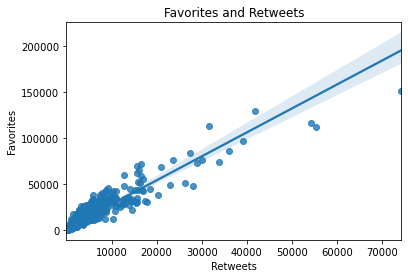

In [475]:
g = sns.regplot(x=df['retweet_count'], y=df['favorite_count'])
plt.title("Favorites and Retweets")
plt.xlabel('Retweets')
plt.ylabel('Favorites')
plt.savefig('ret_fav01')

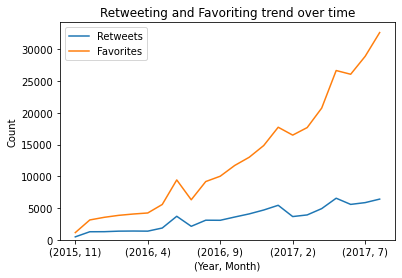

In [476]:
plt.subplots(1, sharex=True)
df['retweet_count'].groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).mean().plot(kind='line')
df['favorite_count'].groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).mean().plot(kind='line').set_ylim(0, )

plt.title('Retweeting and Favoriting trend over time')
plt.ylabel('Count')
plt.xlabel('(Year, Month)')
plt.legend(('Retweets', 'Favorites'))
plt.savefig('ret_fav02')

#### Insight#2
Number of tweets decreased overtime

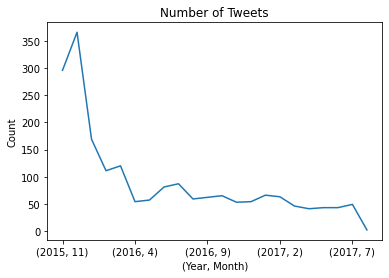

In [477]:
df['tweet_id'].groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).count().plot(kind='line')

plt.title('Number of Tweets')
plt.ylabel('Count')
plt.xlabel('(Year, Month)')
plt.savefig('twt_num');

#### Insight#3
Twitter for iPhone is the most used source for tweeting on the dataset

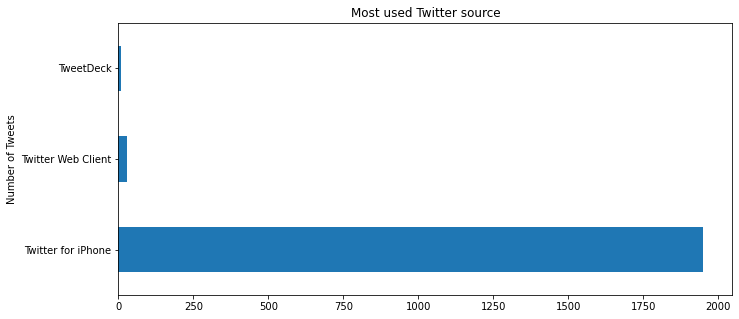

In [478]:
df['source'].value_counts().plot(kind='barh', figsize=(11,5), 
                                                     title='Most used Twitter source').set_ylabel("Number of Tweets")
plt.savefig('twitter_source')

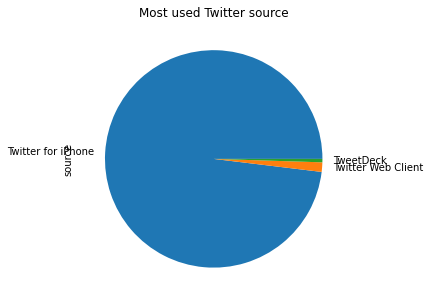

In [479]:
df['source'].value_counts().plot(kind='pie', figsize=(11,5), title='Most used Twitter source');

#### Insight#4
Cooper, Charlie and Oliver are the most dog name 

In [480]:
df['name'].value_counts()[:10]

Cooper     10
Oliver     10
Charlie    10
Lucy        9
Penny       9
Tucker      9
Winston     8
Sadie       8
Toby        7
Lola        7
Name: name, dtype: int64

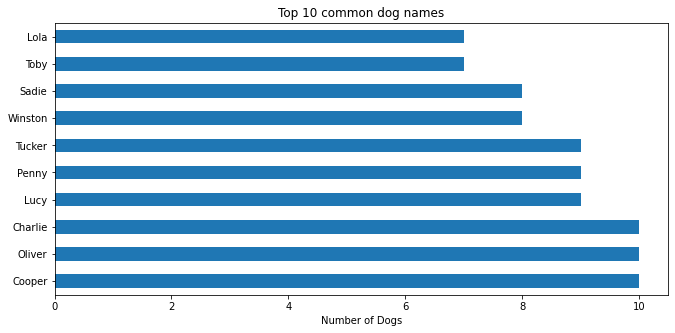

In [481]:
df['name'].value_counts()[:10].plot(kind='barh', figsize=(11,5), 
                                                     title='Top 10 common dog names').set_xlabel("Number of Dogs")
plt.savefig('dog_names')

#### Insight#5
Pupper is the most dog class

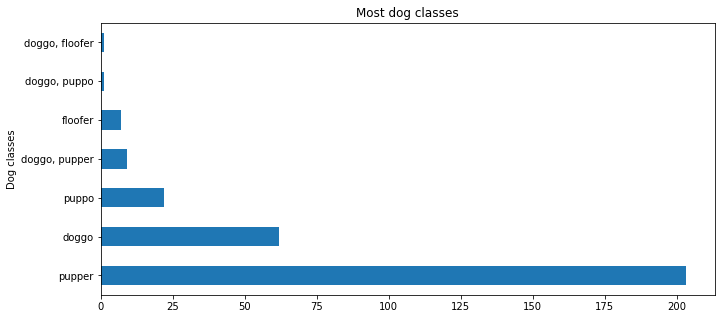

In [482]:
df['dog_class'].value_counts().plot(kind='barh', figsize=(11,5), 
                                                     title='Most dog classes').set_ylabel("Dog classes")
plt.savefig('most_dog_calsses');

#### Insight#6
15% of tweets has a define dog class

In [483]:
with_stage_sum = df['dog_class'].value_counts().sum()
tweets_with_stage = round(with_stage_sum * 100 / twitter_archive_master.shape[0])
print("Number of tweets with dog class :  {}".format(with_stage_sum))
print("Percentage of tweets :             {}%".format(round(tweets_with_stage, 3)))

Number of tweets with dog class :  305
Percentage of tweets :             15%


#### Insight#7
Golden_retriever is the most common dog type in used dataset

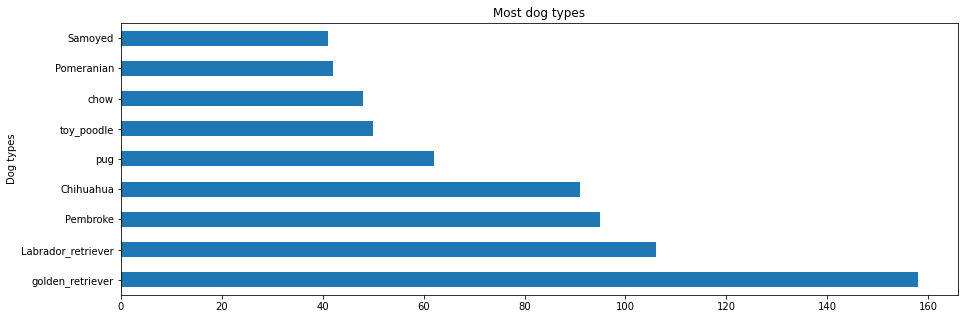

In [484]:
df['dog_type'].value_counts()[1:10].plot(kind='barh', figsize=(15,5), 
                                                     title='Most dog types').set_ylabel("Dog types");
plt.savefig('dog_types');

#### Insight#8
Bedlington_terrier dog type is the most favorite count tweets

In [485]:
df_avg = round(df.groupby('dog_type')['favorite_count'].sum() / df.groupby('dog_type')['favorite_count'].count(),0)
df_avg.sort_values(ascending=False)

dog_type
Bedlington_terrier      22341.0
Saluki                  21522.0
French_bulldog          18149.0
Bouvier_des_Flandres    15926.0
Afghan_hound            15239.0
                         ...   
Tibetan_terrier          1621.0
Irish_wolfhound          1337.0
Japanese_spaniel         1165.0
groenendael              1016.0
Brabancon_griffon         775.0
Name: favorite_count, Length: 114, dtype: float64

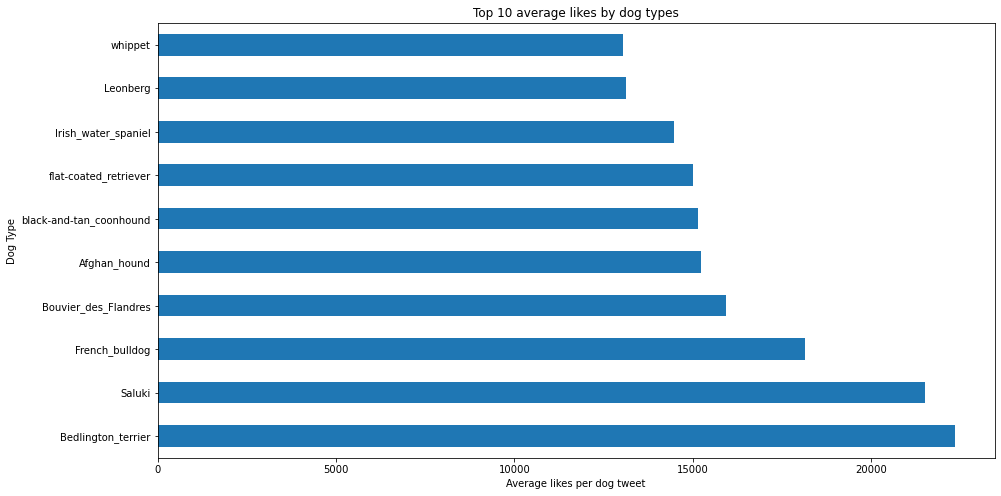

In [486]:
fig = plt.figure(figsize=(15,8))
df_avg.sort_values(ascending=False).nlargest(10).plot(kind='barh')
plt.title("Top 10 average likes by dog types", fontsize=12)
plt.xlabel("Average likes per dog tweet")
plt.ylabel("Dog Type")
plt.savefig('top_likes');